[[  23.926   11.719  121.094   22.949   42.969    0.   ]
 [  22.461   39.062   -9.277   24.414   29.785    0.   ]
 [  23.926   37.109  -19.531   23.926   17.09     0.   ]
 ...
 [  36.621   50.781 -118.652   21.973  -18.066    0.   ]
 [  31.738   48.34  -141.602   19.531  -10.254    0.   ]
 [  34.668   31.738  149.902   25.879   -6.836    0.   ]]
Creating RawArray with float64 data, n_channels=6, n_times=50520
    Range : 0 ... 50519 =      0.000 ...   229.632 secs
Ready.
Using matplotlib as 2D backend.


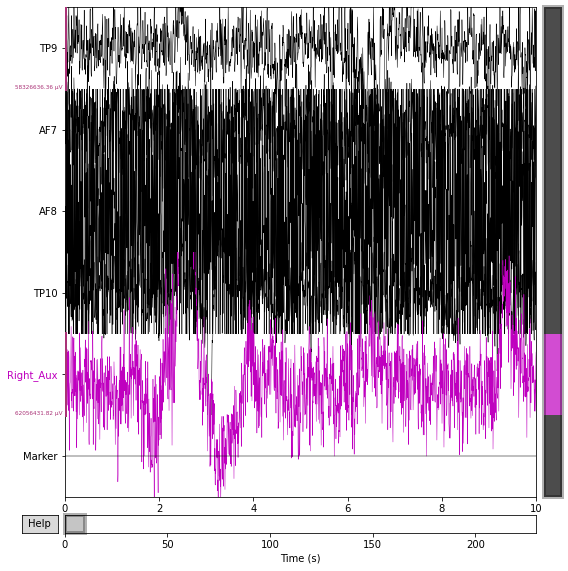

In [1]:
import mne as mne
import numpy as np

# Read the CSV file as a NumPy array

with open(r'./data/115/001_EEG_baseline_stroke_study_updated.csv') as f:
    lines = (line for line in f if not line.startswith('#'))
    FH = np.loadtxt(lines, delimiter=',', skiprows=1)

# removing our first column timestamp
FH = np.delete(FH, 0,1)
# FH = np.delete(FH, 5,1)
# FH = np.delete(FH, 4,1)
# Sampling rate
sfreq = 220  # Hz
print(FH)
channel_names = "TP9 AF7 AF8 TP10 Right_Aux Marker".split()
channel_types = "eeg eeg eeg eeg ecg stim".split()
# Create the info structure needed by MNE
info = mne.create_info(channel_names, sfreq=sfreq, ch_types=channel_types)
info.set_montage('standard_1020')
pure_raw = mne.io.RawArray(np.transpose(FH), info)
raw = pure_raw.copy()
raw.plot(scalings='auto');

['TP9', 'AF7', 'AF8', 'TP10', 'Right_Aux', 'Marker']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 7261 samples (33.005 sec)



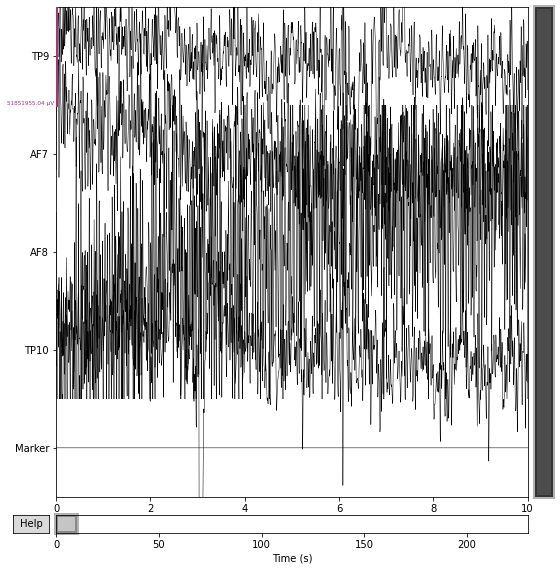

Effective window size : 9.309 (s)


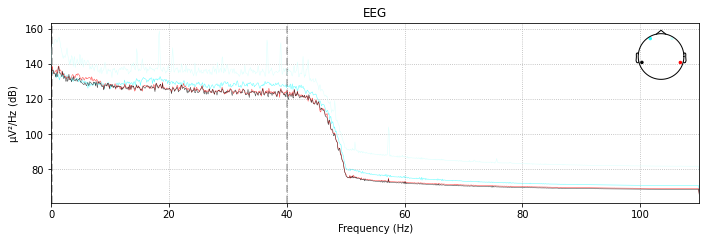

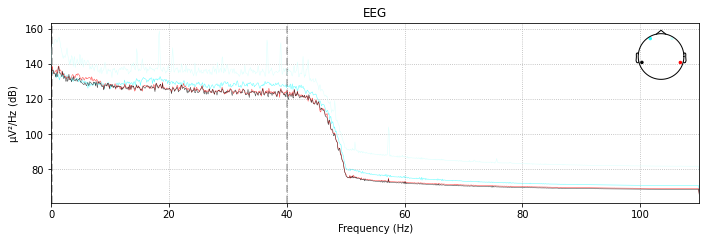

In [2]:
#Define types
print(raw.ch_names)
raw.pick_types(meg=False, eeg=True, ecg=False, stim=True)
raw_copy = raw.copy()
filt_raw = raw_copy.filter(filter_length="auto",l_freq=.1, h_freq=40)

filt_raw.plot(scalings='auto');
filt_raw.plot_psd()

In [4]:
# raw.info["bads"] = "AF7 TP10".split()

In [5]:
events = mne.find_events(filt_raw, stim_channel='Marker')
epochs = mne.Epochs(filt_raw, events, event_id=None, tmin=-0.2, tmax=0.5)

7 events found
Event IDs: [1 2 3 4 5 6 7]
Not setting metadata
Not setting metadata
7 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


In [6]:
from mne.preprocessing import ICA
ica = ICA(n_components=3, method='fastica').fit(epochs)



Fitting ICA to data using 4 channels (please be patient, this may take a while)
Loading data for 7 events and 155 original time points ...
0 bad epochs dropped
Selecting by number: 3 components


C:\Users\tanya\AppData\Local\Temp/ipykernel_31920/1411835069.py:2: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica = ICA(n_components=3, method='fastica').fit(epochs)


Loading data for 7 events and 155 original time points ...
Fitting ICA took 0.2s.


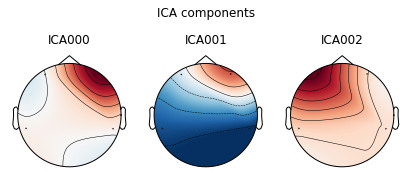

[<MNEFigure size 421.2x187.56 with 3 Axes>]

In [7]:
ica.plot_components()

Loading data for 7 events and 155 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


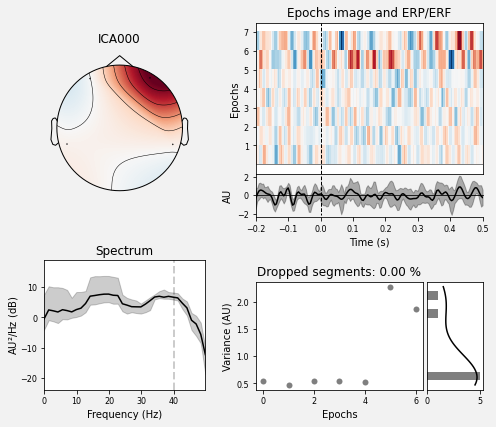

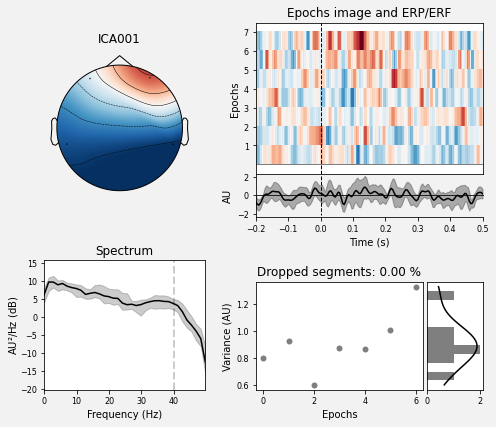

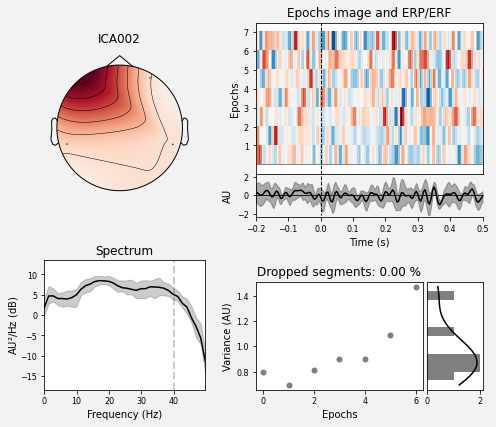

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [8]:

ica.plot_properties(epochs)

Loading data for 7 events and 155 original time points ...
Not setting metadata
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


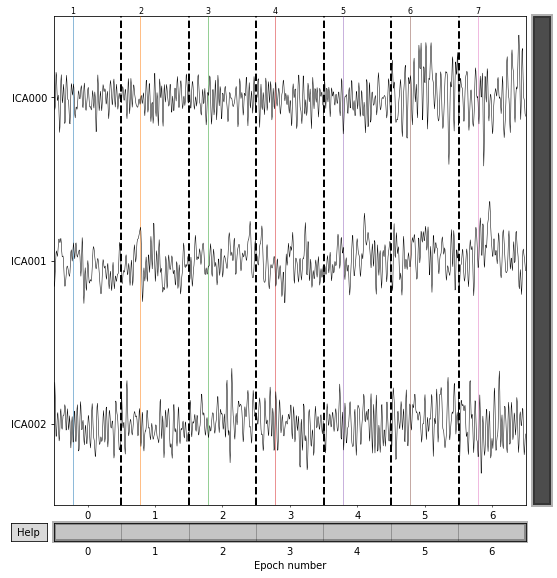

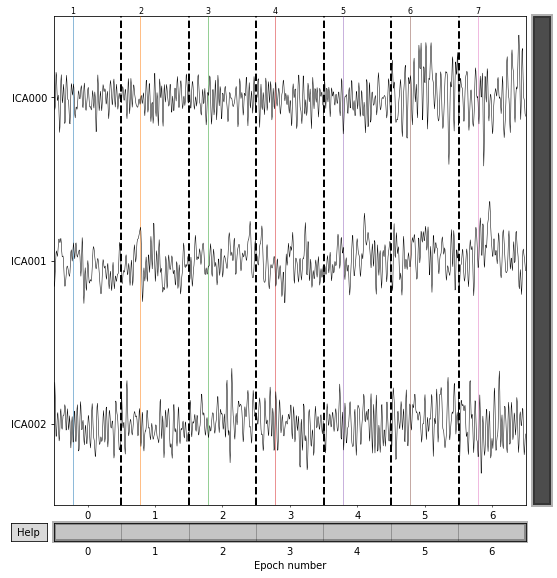

In [9]:
ica.plot_sources(epochs)

Loading data for 7 events and 155 original time points ...
Not setting metadata
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


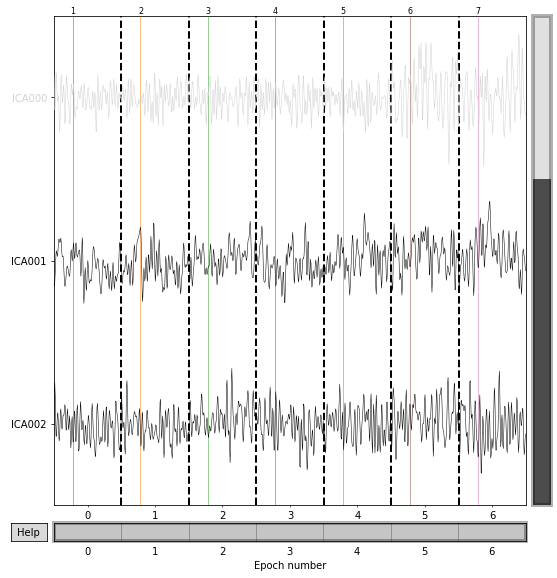

Applying ICA to Raw instance
    Transforming to ICA space (3 components)
    Zeroing out 1 ICA component
    Projecting back using 4 PCA components


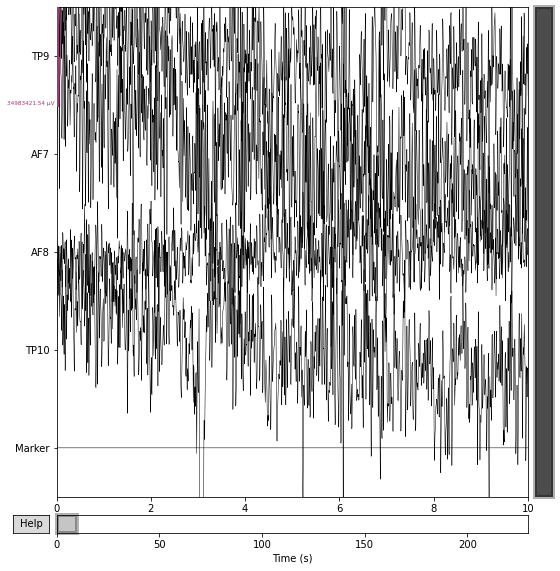

In [11]:
ica.exclude = [0]
ica.plot_sources(epochs)
done = ica.apply(filt_raw)
done.plot(scalings='auto');

Effective window size : 9.309 (s)


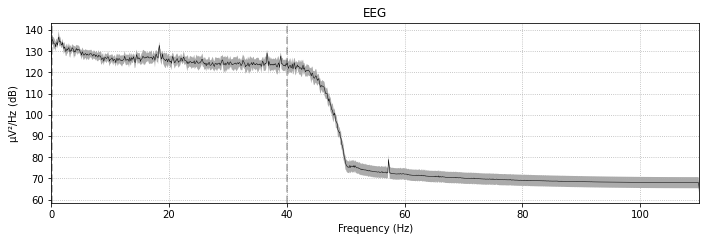

In [12]:
def add_arrows(axes):
    # add some arrows at 60 Hz and its harmonics
    for ax in axes:
        freqs = ax.lines[-1].get_xdata()
        psds = ax.lines[-1].get_ydata()
        for freq in (60, 120, 180, 240):
            idx = np.searchsorted(freqs, freq)
            # get ymax of a small region around the freq. of interest
            y = psds[(idx - 4):(idx + 5)].max()
            ax.arrow(x=freqs[idx-1], y=y + 18, dx=0, dy=-12, color='red',
                     width=0.1, head_width=3, length_includes_head=True)


fig = filt_raw.plot_psd(fmax=110, average=True)
add_arrows(fig.axes[:2])

Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 4 PCA components


C:\Users\tanya\AppData\Local\Temp/ipykernel_31920/1683061804.py:2: RuntimeWarning: Using n_components=4 (resulting in n_components_=4) may lead to an unstable mixing matrix estimation because the ratio between the largest (2.3) and smallest (7.2e-31) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 3
  ica = ICA(n_components=4,method='fastica', random_state=23, max_iter=800).fit(filt_raw)


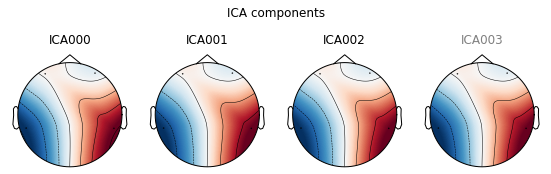

[<MNEFigure size 561.6x187.56 with 4 Axes>]

In [13]:
from mne.preprocessing import ICA
ica = ICA(n_components=4,method='fastica', random_state=23, max_iter=800).fit(filt_raw)
p = "eeg"
ica.exclude =[3]
raw_clean = ica.apply(filt_raw.copy())
ica.plot_components()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


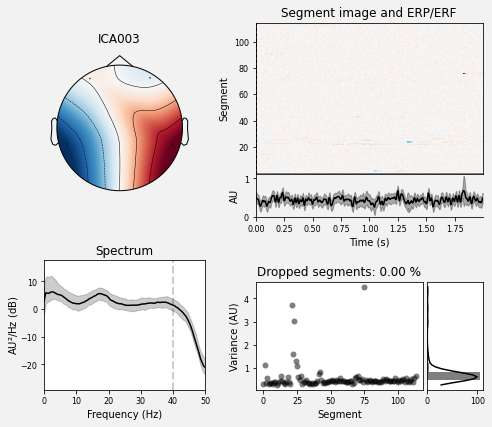

[<Figure size 504x432 with 6 Axes>]

In [14]:
ica.plot_properties(filt_raw, picks=ica.exclude)

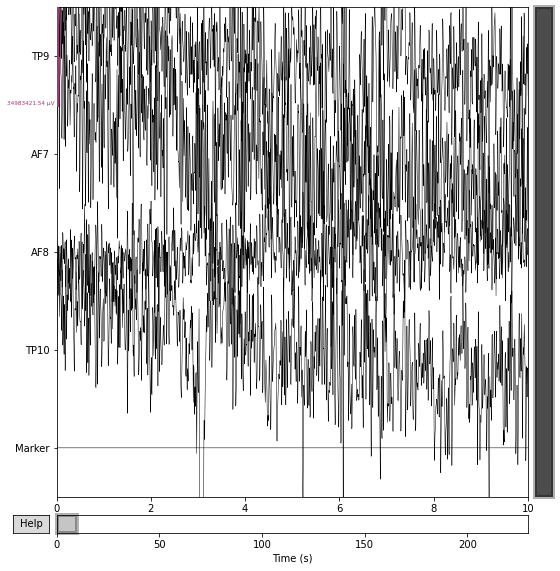

In [15]:

filt_raw.plot(scalings='auto');

Creating RawArray with float64 data, n_channels=4, n_times=50520
    Range : 0 ... 50519 =      0.000 ...   229.632 secs
Ready.


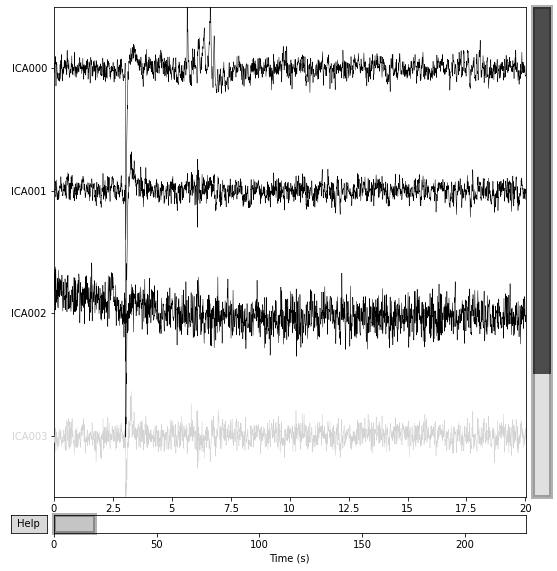

[2]
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 4 PCA components


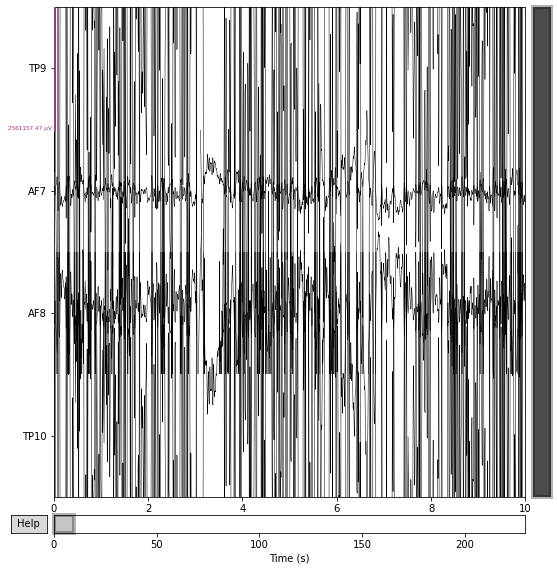

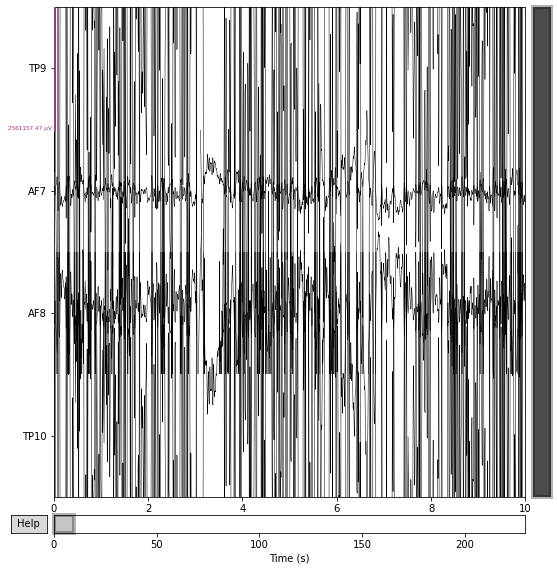

In [16]:
fancy = ica.plot_sources(filt_raw)
filt_raw.pick_types(meg=False, eeg=True, ecg=False, stim=False)
ica.exclude =[2]
print(ica.exclude)
done = ica.apply(filt_raw)
done.plot(scalings='auto');
filt_raw.plot(scalings='auto');

In [15]:
done_df = done.to_data_frame()
done_df.to_csv(r'C:\Users\tanya\OneDrive\Documents\GitHub\LVO-EEG\data\115\001_EEG_baseline_stroke_study_updated_clean_predictive.csv', index=False)	

Above we can see potential ecg interactions, some burst could be explained by blinking

Using channel Right_Aux to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2200 samples (10.000 sec)

Number of ECG events detected : 337 (average pulse 88 / min.)
Not setting metadata
Not setting metadata
337 matching events found
No baseline correction applied
Loading data for 337 events and 221 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


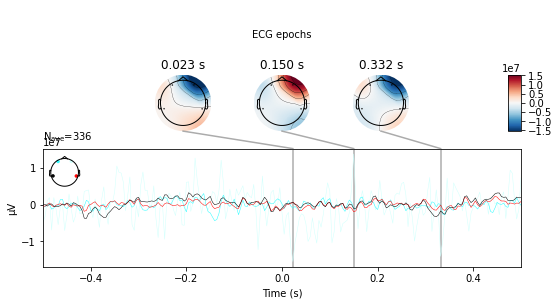

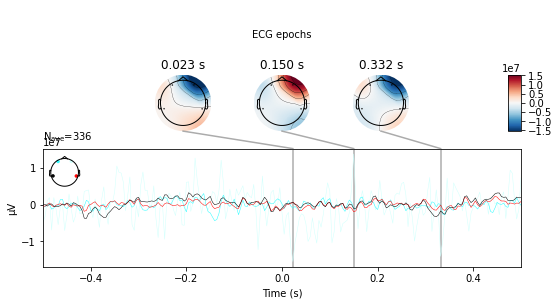

In [16]:
from mne.preprocessing import create_ecg_epochs
ecg_evoked = create_ecg_epochs(pure_raw).average()
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint(title='ECG epochs')

So we'll use ECG to perform our ICA

In [1]:
ica.exclude = []
raw = pure_raw.copy()
# find which ICs match the ECG pattern
ecg_indices, ecg_scores = ica.find_bads_ecg(pure_raw, method='correlation',
                                            threshold='auto')
ica.exclude = ecg_indices
print(ecg_indices)

# barplot of ICA component "ECG match" scores
ica.plot_scores(ecg_scores)

print(ecg_indices)
# plot diagnostics
new_raw = pure_raw.copy()
ica.plot_properties(pure_raw, picks=[3])

# plot ICs applied to raw data, with ECG matches highlighted
ica.plot_sources(filt_raw, show_scrollbars=False)

# plot ICs applied to the averaged ECG epochs, with ECG matches highlighted
ica.plot_sources(ecg_evoked)


NameError: name 'ica' is not defined

Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.1s.


C:\Users\tanya\AppData\Local\Temp/ipykernel_53900/4265333894.py:3: RuntimeWarning: Using n_components=4 (resulting in n_components_=4) may lead to an unstable mixing matrix estimation because the ratio between the largest (3.7) and smallest (3e-33) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 3
  ica.fit(filt_raw,picks="eeg", decim=3, reject=reject)


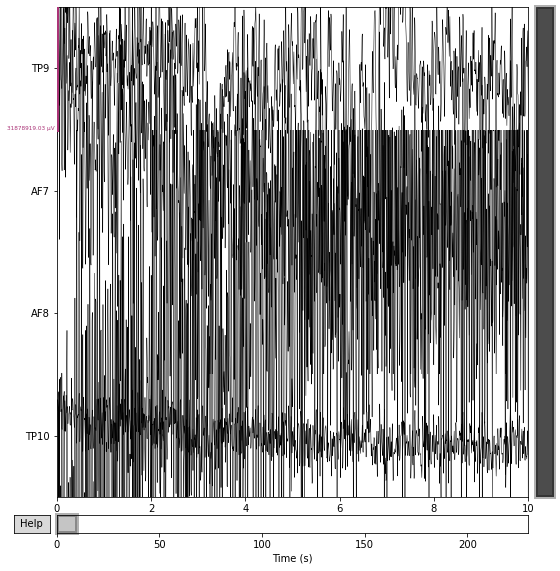

In [18]:
ica.exclude = [0]
reject = dict(mag=4e-12)
ica.fit(filt_raw,picks="eeg", decim=3, reject=reject)
filt_raw.plot(scalings='auto');

<Info | 8 non-empty values
 bads: []
 ch_names: TP9, AF7, AF8, TP10, Marker
 chs: 4 EEG, 1 Stimulus
 custom_ref_applied: False
 dig: 7 items (3 Cardinal, 4 EEG)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 5
 projs: []
 sfreq: 220.0 Hz
>


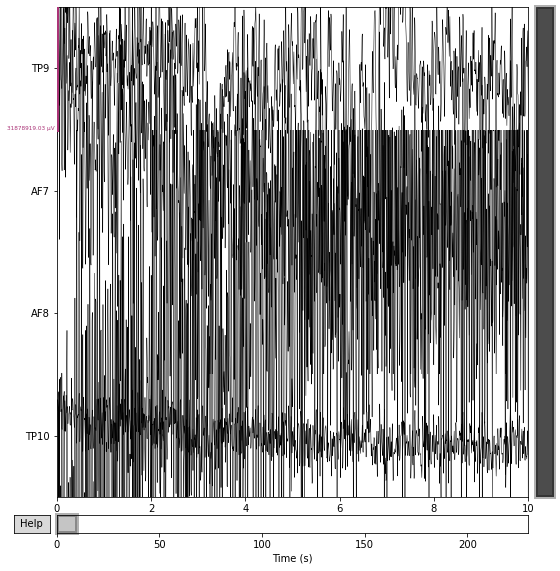

In [19]:
print(raw_clean.info)
filt_raw.plot(scalings='auto');


In [20]:
raw.filter(1,30)
events = mne.find_events(raw)
epochs = mne.Epochs(raw, events=None, event_id=1, tmin=-0.2, tmax=0.5)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 727 samples (3.305 sec)

7 events found
Event IDs: [1 2 3 4 5 6 7]
Not setting metadata
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


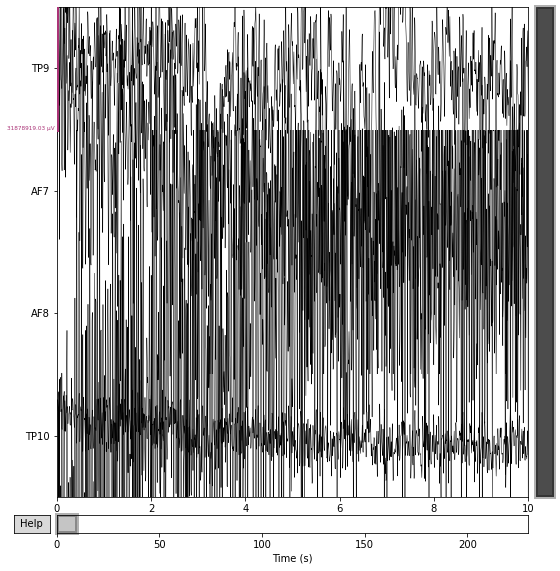

In [21]:
filt_raw.plot(scalings='auto');

In [26]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False)


In [27]:
print(picks)

[0 1 2 3]


Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 3 components
Fitting ICA took 0.1s.


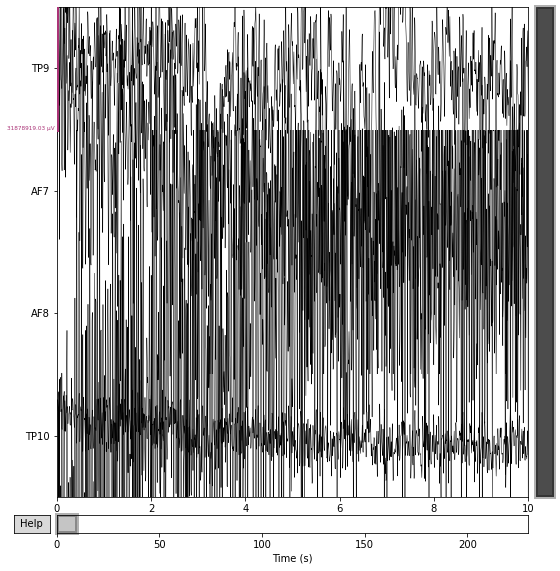

In [28]:
new_ica = ICA(n_components=3, method='fastica', random_state=23, max_iter=800).fit(filt_raw)
filt_raw.plot(scalings='auto');

In [51]:
new_ica.apply(filt_raw)

Applying ICA to Raw instance
    Transforming to ICA space (3 components)
    Zeroing out 0 ICA components
    Projecting back using 4 PCA components


<RawArray | 4 x 50520 (229.6 s), ~1.6 MB, data loaded>

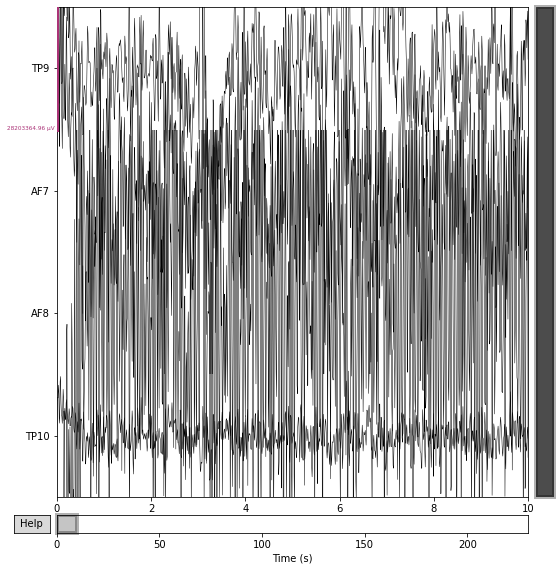

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 5.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Filter length: 727 samples (3.305 sec)



<RawArray | 4 x 50520 (229.6 s), ~1.6 MB, data loaded>

In [55]:
filt_raw.plot(scalings='auto');

In [62]:
import numpy as np

from sklearn.decomposition import FastICA, PCA
ica = FastICA(n_components=3)
raw = pure_raw.copy()
raw.pick_types(meg=False, eeg=True, ecg=False, stim=True)
X = raw.to_data_frame()
S_ = ica.fit_transform(X)

Creating RawArray with float64 data, n_channels=3, n_times=50520
    Range : 0 ... 50519 =      0.000 ...   229.632 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 727 samples (3.305 sec)



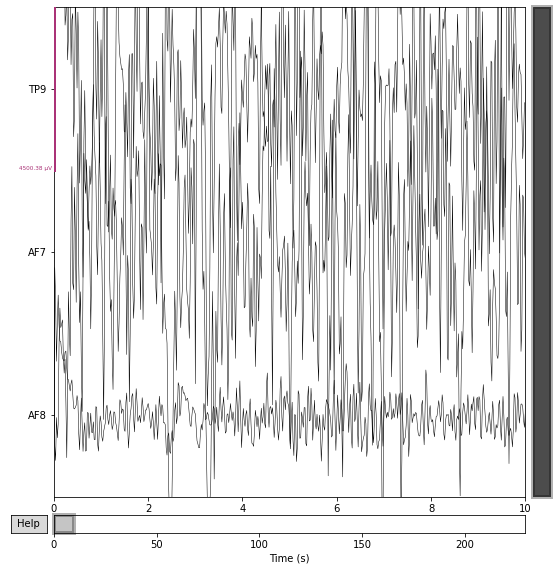

In [65]:

channel_names = "TP9 AF7 AF8".split()
channel_types = "eeg eeg eeg".split()
# Create the info structure needed by MNE
info = mne.create_info(channel_names, sfreq=sfreq, ch_types=channel_types)
info.set_montage('standard_1020')



new = mne.io.RawArray(np.transpose(S_), info)
new.filter(1,15)
new.plot(scalings='auto');